In [84]:
import sklearn
from sklearn.cluster import KMeans,MeanShift,AffinityPropagation
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from TotalCalculation import *
from preprocessing import *
from ClassPrediction import *

In [85]:
df1 = pd.read_csv('GLCM_feature_ALL_sky_6June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df2 = pd.read_csv('GLCM_feature_ALL_sky_12June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df3 = pd.read_csv('GLCM_feature_ALL_sky_16June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df4 = pd.read_csv('GLCM_feature_ALL_sky_23June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df5 = pd.read_csv('GLCM_feature_ALL_sky_27June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df6 = pd.read_csv('GLCM_feature_ALL_sky_2June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df7 = pd.read_csv('GLCM_feature_ALL_sky_9June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df8 = pd.read_csv('GLCM_feature_ALL_sky_14June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df9 = pd.read_csv('GLCM_feature_ALL_sky_19June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df10 = pd.read_csv('GLCM_feature_ALL_sky_24June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df11 = pd.read_csv('GLCM_feature_ALL_sky_1June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df12 = pd.read_csv('GLCM_feature_ALL_sky_4June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df13 = pd.read_csv('GLCM_feature_ALL_sky_7June_dis3_ang45_test.csv',index_col='Unnamed: 0')
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13])

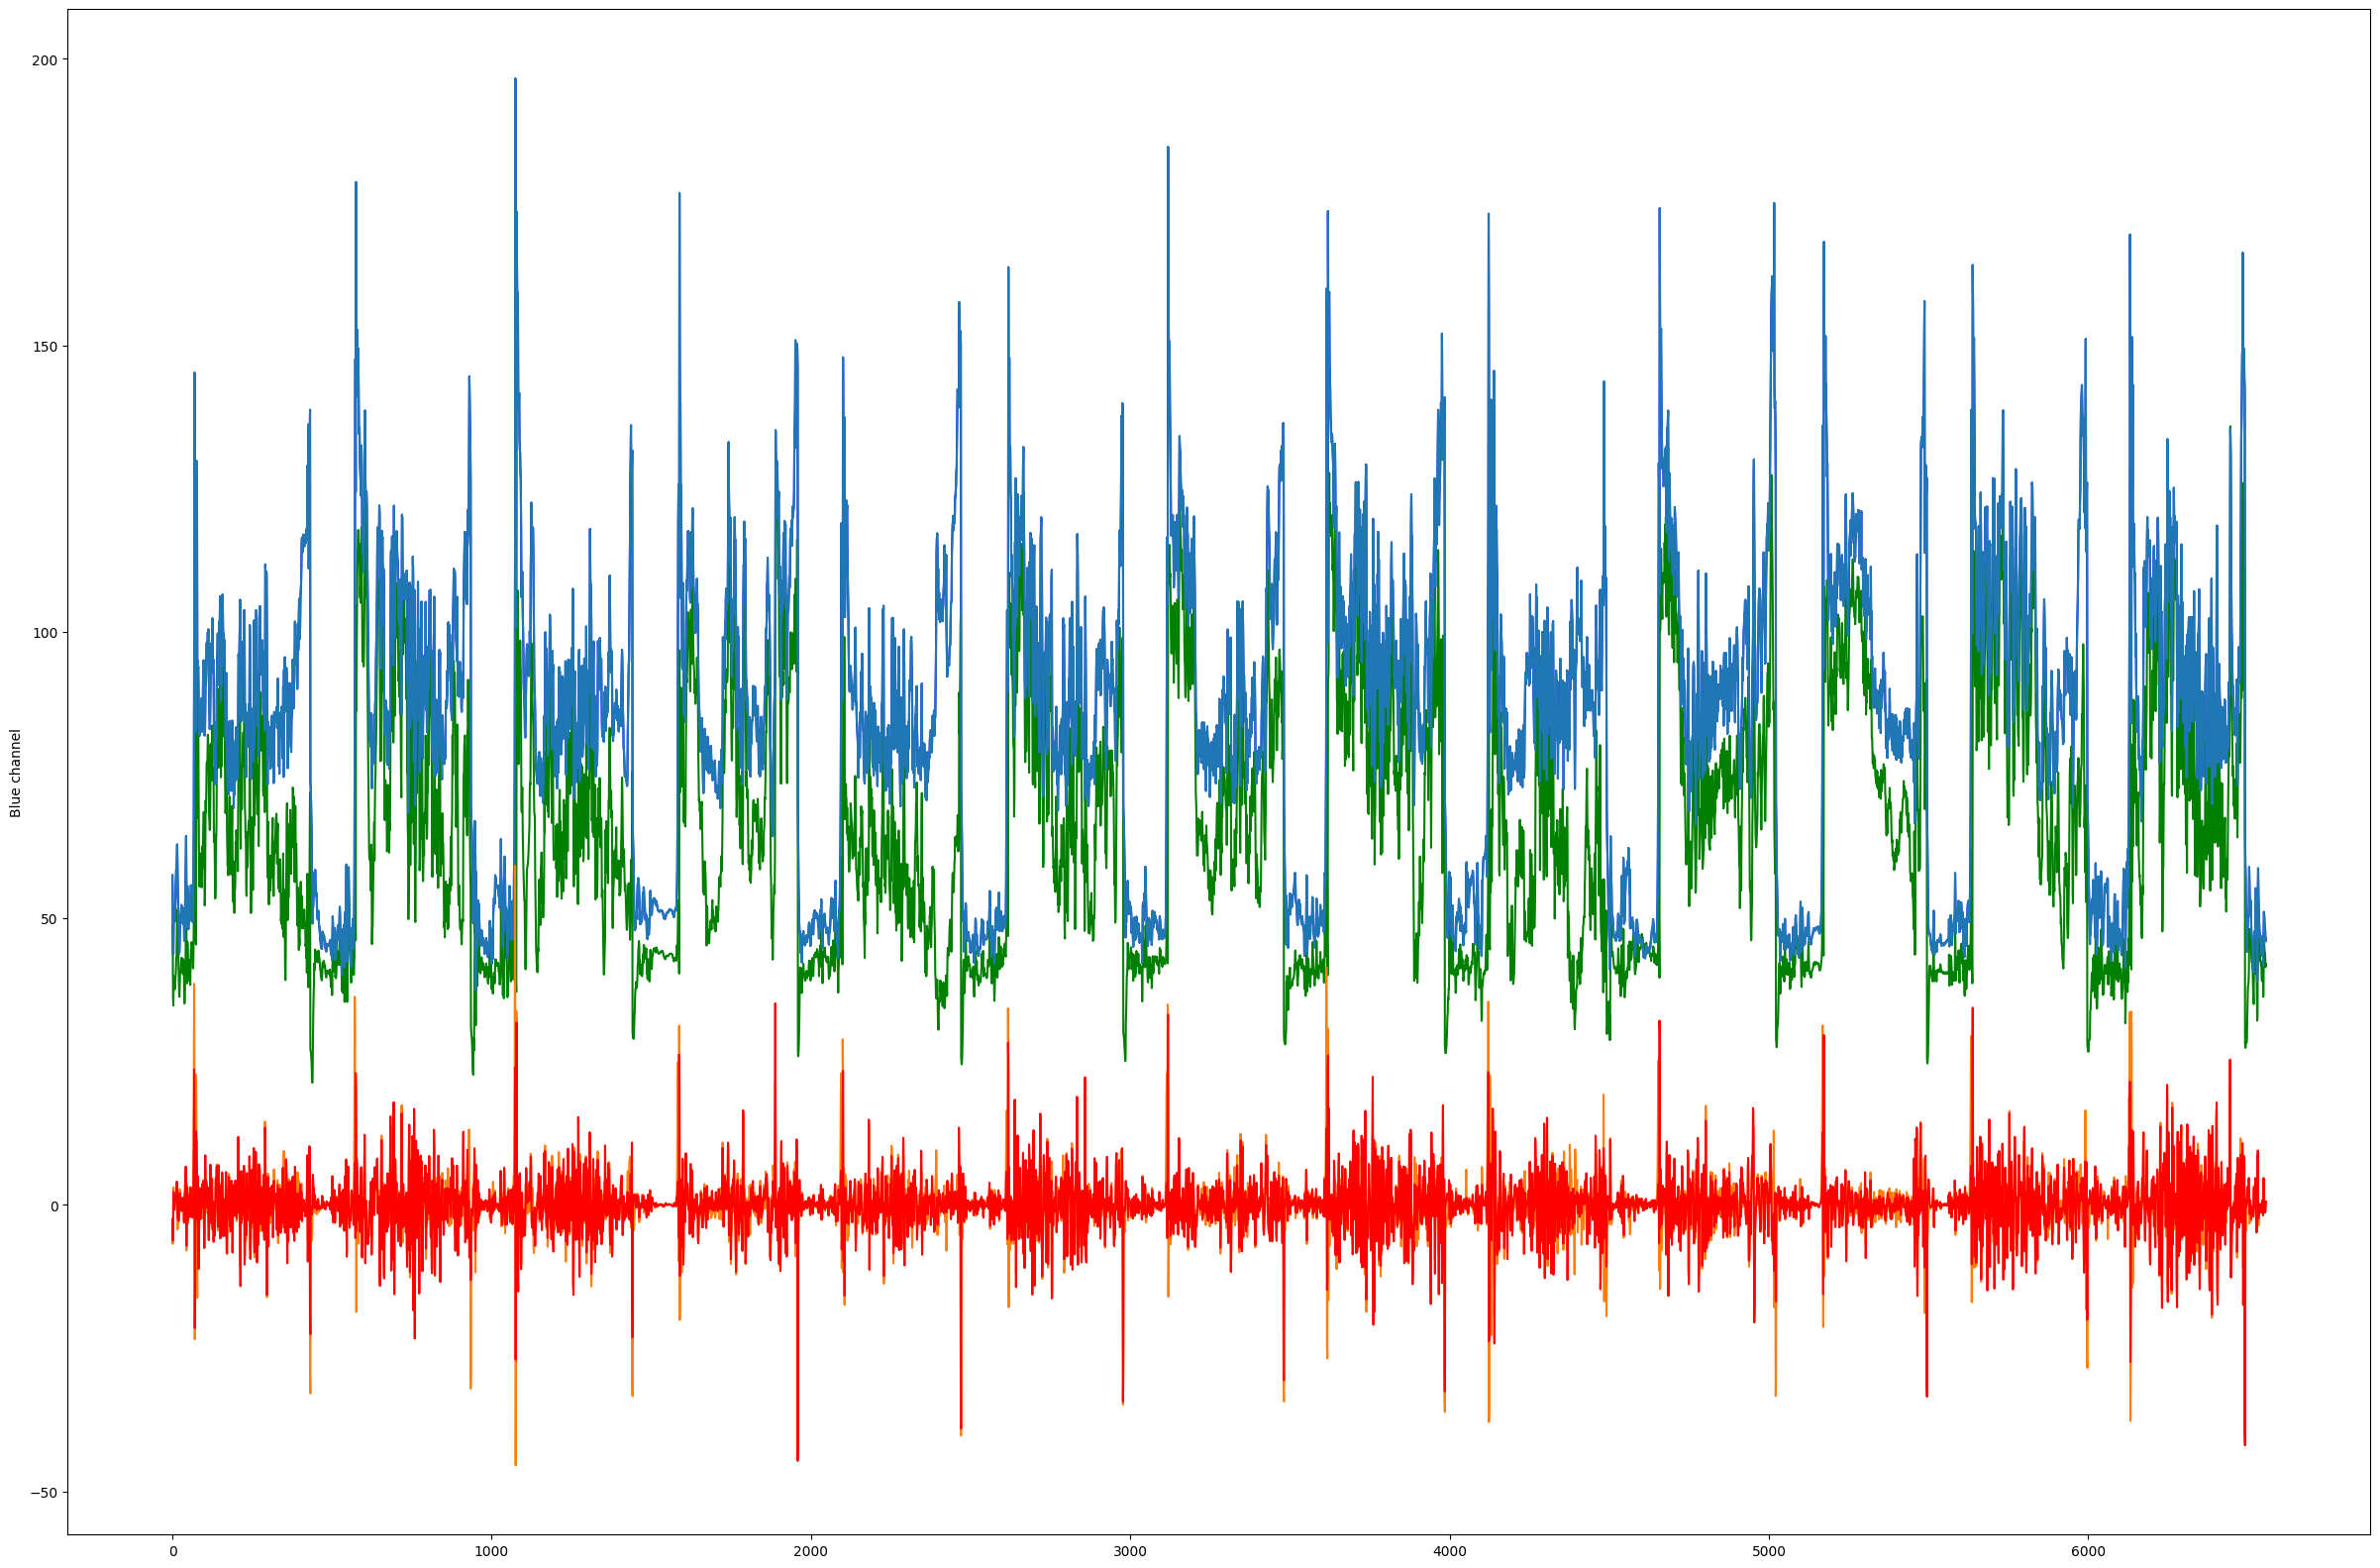

In [86]:
name_y = str('Blue channel')
name_x = np.arange(len(df))
dintr = np.gradient(df['Blue channel'])
dintb = np.gradient(df['Red channel'])

plt.figure(figsize=(30,20))
sns.lineplot(data=df,x=name_x,y=df[name_y],c='blue')
sns.lineplot(data=df,x=name_x,y=df['Red channel'],c='green')
sns.lineplot(data=df,x=name_x,y=df['intensity'])
plt.plot(dintr)
plt.plot(dintb,c='r')

In [87]:
date = []
for i in df.index.tolist():
    date.append(timeConvertion.ticks_to_datetime(i,time_zone=7))
df['Time'] = date


In [88]:
df

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,intensity,Red channel,Blue channel,Time
638532036976060290,126.219234,2.753987,0.643698,0.270271,0.960653,0.073046,57.510273,48.711309,57.510273,2024-06-06 00:01:37.606032
638532039676516564,176.078124,2.917896,0.745345,0.434567,0.946230,0.188848,53.441624,46.138830,53.441624,2024-06-06 00:06:07.651656
638532042377577057,131.234135,2.375223,0.801652,0.566645,0.942462,0.321087,43.872300,36.193593,43.872300,2024-06-06 00:10:37.757704
638532045078554651,163.274635,2.585655,0.846777,0.706481,0.918515,0.499116,43.750838,34.772768,43.750838,2024-06-06 00:15:07.855464
638532047778900754,124.581209,2.954809,0.703002,0.432451,0.952718,0.187014,49.867804,39.865546,49.867804,2024-06-06 00:19:37.890072
...,...,...,...,...,...,...,...,...,...,...
638533751475753073,56.448550,1.762068,0.692031,0.228806,0.978708,0.052352,49.153434,44.472817,49.153434,2024-06-07 23:39:07.575304
638533754176407834,53.511006,1.592313,0.724008,0.242879,0.978799,0.058990,48.644405,44.126121,48.644405,2024-06-07 23:43:37.640784
638533756876296196,54.756128,1.606955,0.733678,0.262830,0.978809,0.069080,48.019851,43.479776,48.019851,2024-06-07 23:48:07.629616
638533759476998423,63.883875,1.673230,0.760528,0.307751,0.974681,0.094711,45.991761,41.471875,45.991761,2024-06-07 23:52:27.699840


In [89]:
df['Time (decimal)'] = df['Time'].dt.hour+df['Time'].dt.minute/60

In [90]:
start_date = '2024-01-01'
end_date = str(df['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion.time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise,sunset = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

In [91]:
df = df[(df['Time (decimal)'] > sunrise) & (df['Time (decimal)'] < sunset)]

In [92]:
x = df.drop(columns=['Time (decimal)','Time','intensity','Blue channel'])

dataset = list(x.itertuples(index=False,name=None))
dataset = np.array(dataset)

<Axes: >

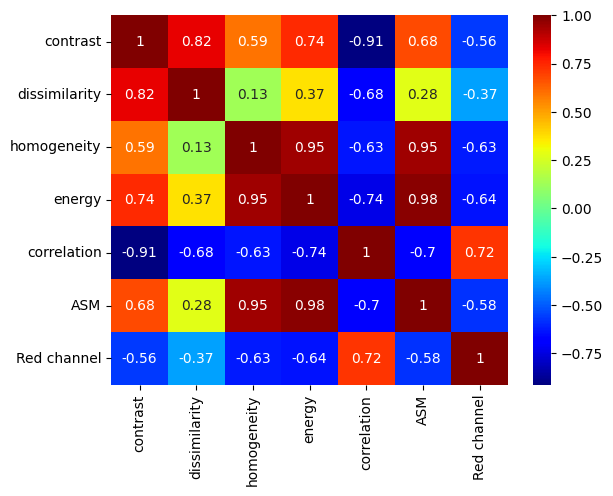

In [93]:
sns.heatmap(data=x.corr(),cmap='jet',annot=True)

In [94]:
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(42)

kmeans = KMeans(n_clusters=5, tol=1e-5, random_state=42, init='random' ,n_init=20, max_iter=500, algorithm='elkan')
af = AffinityPropagation(damping=0.95, max_iter=500, convergence_iter=20, preference=-50, affinity='euclidean')
GMM = GaussianMixture(n_components=5, tol=1e-4, init_params='kmeans',covariance_type='full', max_iter=500, random_state=42, n_init=10)
labels = GMM.fit_predict(dataset)
labels_kmean = kmeans.fit_predict(dataset)
labels_af = af.fit_predict(dataset)

In [95]:
df.loc[:, 'Label_GMM'] = labels
df.loc[:, 'Label_Kmean'] = labels_kmean
#df.loc[:, 'Label_AF'] = labels_af

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21760\2933432740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Label_GMM'] = labels
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21760\2933432740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Label_Kmean'] = labels_kmean


<Axes: xlabel='correlation', ylabel='contrast'>

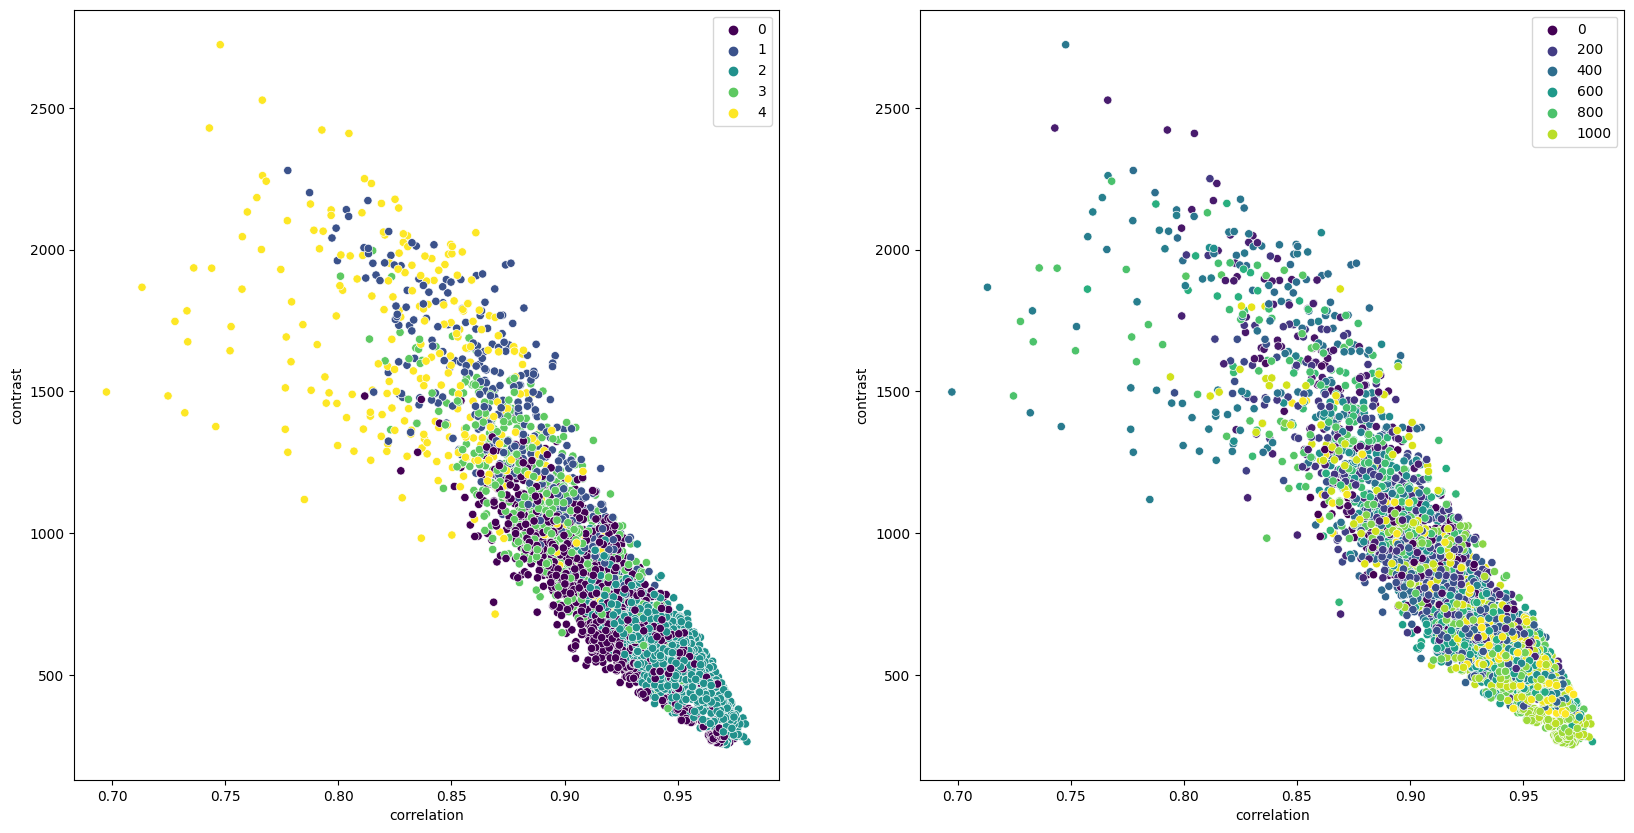

In [96]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(data=df,x=df['correlation'],y=df['contrast'],hue=labels,palette='viridis')
plt.subplot(1,2,2)
sns.scatterplot(data=df,x=df['correlation'],y=df['contrast'],hue=labels_af,palette='viridis')


In [97]:
silhouette_avg = silhouette_score(dataset, labels_kmean)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.517989589799902


In [98]:
print(GMM.bic(dataset))

-8374.818215544561


In [99]:
silhouette_avg = silhouette_score(dataset, labels_af)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.33598419802168594


In [100]:
import pickle 

with open('af_model_1.pkl','wb') as f:
    pickle.dump(af,f)

In [101]:
import pickle
with open('gmm_model_2.pkl', 'wb') as f:
    pickle.dump(GMM, f)
with open('kmean_model_2.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

viz = visualizer()
number = 1
source_folder = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-12'
destination_folder = r'C:\Users\ASUS\Documents\NARIT_internship_2024\Tester'

viz.copy_matching_files(df=viz.match_label(df=df,number=number), source_folder=source_folder, destination_folder=destination_folder)

pred = prediction()
path = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-09\638534868144584540.png'
pred_1,pred_2,cloud_percentage,sky_status,final = pred.total_prediction(image_path=path,mask_path='mask_delete_5.png',crop_size=570,kmeans=kmeans,GMM=GMM,df=df)

mask = cv2.imread('mask_delete_5.png',cv2.IMREAD_GRAYSCALE)
mask = crop_center(img=mask,crop_size=570)
img,name = load_single_image(path=path,crop_size=570,mask=mask,apply_crop_sun=False)
image,value,RB = pred.RBsingle(input=img,dataframe=df)
cloud_ratio = pred.CloudRatio(image=img,mask=mask)

import requests
import cv2
import numpy as np
import hashlib
import time

def get_image_hash(image_data):
    return hashlib.md5(image_data).hexdigest()

image_url = "http://weather.narit.or.th/images/allskyimage/ASTROPARK/2024-08-19"
previous_hash = None

while True:
    # Fetch the image from the web
    response = requests.get(image_url)
    if response.status_code == 200:
        # Get the current hash of the image
        current_hash = get_image_hash(response.content)
        
        # Compare with the previous hash
        if current_hash != previous_hash:
            # The image has changed
            print("Image has changed, updating display...")
            image_array = np.frombuffer(response.content, np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            cv2.imshow('Auto-Updated Image', image)
            
            # Update the previous hash
            previous_hash = current_hash
            
            # Wait for 1 second to avoid rapid flickering
            if cv2.waitKey(1000) & 0xFF == ord('q'):
                break
        else:
            print("No change detected.")
    
    # Check every 10 seconds for a change
    time.sleep(10)
    cv2.destroyAllWindows()
